In [1]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 19.7 MB/s eta 0:00:00a 0:00:01


# Đọc dữ liệu

In [2]:
import pandas as pd
import networkx as nx

In [3]:
PATH = "/kaggle/input/rnn-with-meetup/data/"

In [4]:
member_edge = pd.read_csv("/kaggle/input/member-edges-25k/member_edges_25k.csv", index_col=0)

meta_groups = pd.read_csv(PATH + "meta-groups.csv")
meta_members = pd.read_csv(PATH + "meta-members.csv")

In [5]:
member_edge.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24962 entries, 4974 to 11125
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   member1  24962 non-null  int64
 1   member2  24962 non-null  int64
 2   weight   24962 non-null  int64
dtypes: int64(3)
memory usage: 780.1 KB


In [6]:
meta_members.head()

,member_id,name,hometown,city,state,lat,lon
0,2069,Wesley Duffee-Braun,Brentwood,Brentwood,TN,36.00,-86.79
1,8386,Tim,Nashville,Nashville,TN,36.07,-86.78
2,9205,Brenda,Brentwood,Brentwood,TN,36.00,-86.79
3,17903,Steve,NaN,Nashville,TN,36.13,-86.80
4,20418,Andrea Reynolds,"Huntington, WV",Nashville,TN,36.17,-86.72


In [7]:
meta_groups.head()

,group_id,group_name,num_members,category_id,category_name,organizer_id,group_urlname
0,339011,Nashville Hiking Meetup,15838,23,Outdoors & Adventure,4353803,nashville-hiking
1,19728145,Stepping Out Social Dance Meetup,1778,5,Dancing,118484462,steppingoutsocialdance
2,6335372,Nashville soccer,2869,32,Sports & Recreation,108448302,Nashville-soccer
3,10016242,NashJS,1975,34,Tech,8111102,nashjs
4,21174496,20's & 30's Women looking for girlfriends,2782,31,Socializing,184580248,new-friends-in-Nashville


# Xóa bớt liên kết

***Vì train nhiều dữ liệu bị tràn ram**

In [8]:
member_edge_eq1 = member_edge[member_edge['weight'] == 1]
member_edge_eq1 = member_edge_eq1.iloc[:13000,:]
member_edge_eq1['Is_friend'] = 0
member_edge_eq1

,member1,member2,weight,Is_friend
Unnamed: 0,,,,
24502,28573892,176110612,1,0
18281,195657825,203184347,1,0
23394,195231923,161882042,1,0
19189,228655199,183381715,1,0
17205,204669023,208064791,1,0
...,...,...,...,...
20971,96862332,74830542,1,0
23030,216367274,42955792,1,0
21862,85557392,193874577,1,0


In [9]:
member_edge_NOT_eq1 = member_edge[member_edge['weight'] != 1]
member_edge_NOT_eq1['Is_friend'] = 1
member_edge_NOT_eq1 = member_edge_NOT_eq1.iloc[:12000,:]
member_edge_NOT_eq1

/tmp/ipykernel_33/1294304853.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  member_edge_NOT_eq1['Is_friend'] = 1


,member1,member2,weight,Is_friend
Unnamed: 0,,,,
4974,211551769,158793082,2,1
5622,32671432,110832222,2,1
2756,214729620,204412550,2,1
1252,214761951,211626236,2,1
10342,223055408,189716705,2,1
...,...,...,...,...
5410,7964302,7980746,2,1
1018,226853216,222157019,2,1
5646,32671432,11107841,2,1


In [10]:
# member = pd.concat([member_edge_NOT_eq1,member_edge_eq1]).reset_index(drop=True)
# member = member.sample(frac = 1, random_state=22)
# member = member.drop(columns=['Is_friend'])
# member.to_csv('member_edges_new.csv')

In [11]:
member_edge = pd.concat([member_edge_NOT_eq1,member_edge_eq1]).reset_index(drop=True)
member_edge = member_edge.sample(frac = 1, random_state=22)
member_edge

,member1,member2,weight,Is_friend
22496,205193250,185666200,1,0
10441,14486634,11421826,2,1
10307,14225169,190664107,2,1
18372,195657825,231812516,1,0
12048,195657825,59162062,1,0
...,...,...,...,...
23030,217350178,197966717,1,0
21862,229310518,225287724,1,0
24932,190939281,49647392,1,0
22660,191758521,10083446,1,0


array([[<Axes: title={'center': 'member1'}>,
        <Axes: title={'center': 'member2'}>],
       [<Axes: title={'center': 'weight'}>,
        <Axes: title={'center': 'Is_friend'}>]], dtype=object)

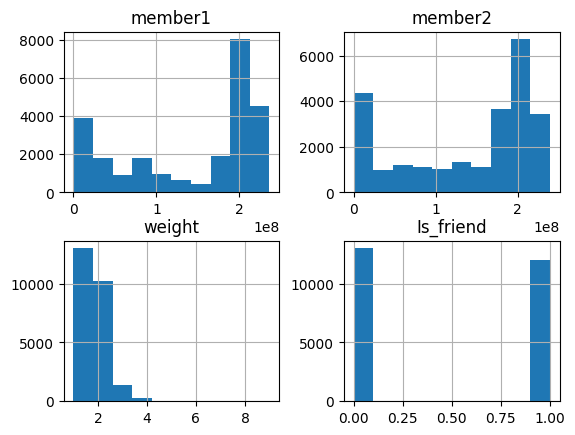

In [12]:
member_edge.hist()

In [13]:
member_edge = member_edge.drop(columns=['weight'])
member_edge

,member1,member2,Is_friend
22496,205193250,185666200,0
10441,14486634,11421826,1
10307,14225169,190664107,1
18372,195657825,231812516,0
12048,195657825,59162062,0
...,...,...,...
23030,217350178,197966717,0
21862,229310518,225287724,0
24932,190939281,49647392,0
22660,191758521,10083446,0


# Convert Member to Homogeneous Graph

Let's first identify the graph-specific things we need:

- `Nodes` - Members (by ID)
- `Edges` - Weight-Shared group membership
- `Node Features` - hometown, city, state, lat, lon (3 atts maybe affact to Weight)
- `Labels` - Weight-Shared group membership (node-level regression task)

In [14]:
from sklearn import preprocessing
import numpy as np

In [15]:
# Make sure that we have no duplicate nodes
max(meta_members["member_id"].value_counts())

1

## Delete member note edge

In [16]:
meta_members[meta_members.member_id==198016947]

,member_id,name,hometown,city,state,lat,lon
13190,198016947,Talyna Kellum,NaN,Fairview,TN,35.97,-87.13


In [17]:
member_inp_edge = member_edge[member_edge['member1'].isin(meta_members.member_id)]
member_inp_edge = member_inp_edge[member_inp_edge['member2'].isin(meta_members.member_id)]
member_label_edge = member_edge[member_edge['member2'].isin(meta_members.member_id)]

In [18]:
# member_inp_edge = member_inp_edge[(member_inp_edge['weight'] == 1)]
# member_label_edge = member_label_edge[(member_label_edge['weight'] == 1)]

len (member_inp_edge) , len (member_label_edge)

(24961, 24961)

In [19]:
member_inp_meta_1 = meta_members.rename(columns = {'member_id':'member1'})
member_inp_meta_2 = meta_members.rename(columns = {'member_id':'member2'})
member_inp_meta_1

,member1,name,hometown,city,state,lat,lon
0,2069,Wesley Duffee-Braun,Brentwood,Brentwood,TN,36.00,-86.79
1,8386,Tim,Nashville,Nashville,TN,36.07,-86.78
2,9205,Brenda,Brentwood,Brentwood,TN,36.00,-86.79
3,17903,Steve,NaN,Nashville,TN,36.13,-86.80
4,20418,Andrea Reynolds,"Huntington, WV",Nashville,TN,36.17,-86.72
...,...,...,...,...,...,...,...
24586,239513469,Madison Ray,NaN,Nashville,TN,36.09,-86.82
24587,239515413,Jay Hatchett,NaN,La Vergne,TN,36.00,-86.57
24588,239519977,Lukasz Bielawski,NaN,Nashville,TN,36.17,-86.78
24589,239520184,Terri Taylor,NaN,Nashville,TN,36.14,-86.74


In [20]:
member_inp_meta_1 = pd.merge(member_edge, member_inp_meta_1, how="inner", on=["member1"])
member_inp_meta_1

,member1,member2,Is_friend,name,hometown,city,state,lat,lon
0,205193250,185666200,0,Otilia Bilauca,NaN,Brentwood,TN,36.00,-86.79
1,205193250,209704842,0,Otilia Bilauca,NaN,Brentwood,TN,36.00,-86.79
2,205193250,186045687,0,Otilia Bilauca,NaN,Brentwood,TN,36.00,-86.79
3,205193250,197541214,0,Otilia Bilauca,NaN,Brentwood,TN,36.00,-86.79
4,205193250,202429218,0,Otilia Bilauca,NaN,Brentwood,TN,36.00,-86.79
...,...,...,...,...,...,...,...,...,...
24957,194381707,11872972,1,Shawn,Nashville,Nashville,TN,36.17,-86.78
24958,13371408,12134295,1,RJ,"Antioch, TN",Antioch,TN,36.04,-86.64
24959,38505422,12128207,1,Jess,"Jamestown, TN",Nashville,TN,36.17,-86.78
24960,6458794,3380276,1,Lannae,Nashville,Nashville,TN,36.16,-86.79


In [21]:
member_inp_meta_1 = member_inp_meta_1.dropna(subset=['member2'])
member_inp_meta_1["member2"] = member_inp_meta_1["member2"].astype(int)

In [22]:
meta_edge_members = pd.merge(member_edge, member_inp_meta_2, how="inner", on=["member2"])
meta_edge_members

,member1,member2,Is_friend,name,hometown,city,state,lat,lon
0,205193250,185666200,0,Mike Brown,NaN,Nashville,TN,36.17,-86.72
1,195657825,185666200,0,Mike Brown,NaN,Nashville,TN,36.17,-86.72
2,204669023,185666200,0,Mike Brown,NaN,Nashville,TN,36.17,-86.72
3,28573892,185666200,0,Mike Brown,NaN,Nashville,TN,36.17,-86.72
4,14486634,11421826,1,kevin.reiss,Franklin,Franklin,TN,35.93,-86.81
...,...,...,...,...,...,...,...,...,...
24956,195657825,197747639,0,Mike Schmitz,NaN,Lebanon,TN,36.21,-86.31
24957,7864416,226853216,0,Jackson Guerrier,NaN,Nashville,TN,36.17,-86.78
24958,214466652,217977208,0,Emma Reynolds,NaN,Nashville,TN,36.17,-86.78
24959,217350178,107048712,0,Jonathan,"Miami, FL",Nashville,TN,36.15,-86.86


In [23]:
meta_edge_members = meta_edge_members.dropna(subset=['member1'])
meta_edge_members["member1"] = meta_edge_members["member1"].astype(int)

In [24]:
# meta_members = pd.concat([result_1,result_2]).reset_index(drop=True)
# member_inp_meta_1 = member_inp_meta_1.rename(columns = {'member1':'member_id'})

## Node_features

In [25]:
# Sort to define the order of nodes
sorted_df = member_inp_meta_1.sort_values(by="member1")
# Select node features
## hometown miss a lot value
node_features = sorted_df[["city", "state" , "lat", "lon"]]
# Fill nan
node_features["state"] = node_features["state"].fillna("Nashville")

/tmp/ipykernel_33/4117103657.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  node_features["state"] = node_features["state"].fillna("Nashville")


In [26]:
# Convert non-numeric columns
pd.set_option('mode.chained_assignment', None)
enc_city = preprocessing.OrdinalEncoder()
enc_state = preprocessing.OrdinalEncoder()

node_features["city_encode"] = node_features["city"]
node_features["state_encode"] = node_features["state"]

node_features[["city_encode"]] = enc_city.fit_transform(node_features[["city_encode"]])
node_features[["state_encode"]] = enc_city.fit_transform(node_features[["state_encode"]])

In [27]:
node_features.drop(["city", "state"], axis=1, inplace=True)

In [28]:
node_features.head()

,lat,lon,city_encode,state_encode
21938,36.0,-86.79,6.0,13.0
21956,36.0,-86.79,6.0,13.0
21953,36.0,-86.79,6.0,13.0
21952,36.0,-86.79,6.0,13.0
21951,36.0,-86.79,6.0,13.0


In [29]:
# Convert to numpy
x = node_features.to_numpy()
x.shape # [num_nodes x num_features]

(24962, 4)

## Labels

In [30]:
sorted_df = member_inp_meta_1.sort_values(by="member1")
labels = sorted_df["Is_friend"]
labels.tail()

22790    1
22789    1
22788    1
22784    1
22792    1
Name: Is_friend, dtype: int64

In [31]:
# Convert to numpy
y = labels.to_numpy()
y.shape

(24962,)

## Mask node

In [32]:
import torch

# Create valid masks for nodes
is_friend = np.array(sorted_df["Is_friend"], dtype=np.float32)
valid_mask = np.argwhere(~np.isnan(is_friend)).reshape(-1)
torch_valid_mask = torch.tensor(valid_mask, dtype=torch.long)
torch_valid_mask

tensor([    0,     1,     2,  ..., 24959, 24960, 24961])

## Edges

In [33]:
member_inp_meta_1.head()

,member1,member2,Is_friend,name,hometown,city,state,lat,lon
0,205193250,185666200,0,Otilia Bilauca,NaN,Brentwood,TN,36.0,-86.79
1,205193250,209704842,0,Otilia Bilauca,NaN,Brentwood,TN,36.0,-86.79
2,205193250,186045687,0,Otilia Bilauca,NaN,Brentwood,TN,36.0,-86.79
3,205193250,197541214,0,Otilia Bilauca,NaN,Brentwood,TN,36.0,-86.79
4,205193250,202429218,0,Otilia Bilauca,NaN,Brentwood,TN,36.0,-86.79


In [34]:
sorted_df = member_inp_meta_1.sort_values(by="member1").set_index("member1")
# sorted_df_1 = member_edge.sort_values(by="member1").set_index("member1")
# sorted_df_2 = member_edge.sort_values(by="member2").set_index("member2")

In [35]:
sorted_df = sorted_df.reset_index(drop=False)
# sorted_df_1 = sorted_df_1.reset_index(drop=False)
# sorted_df_2 = sorted_df_2.reset_index(drop=False)
member_id_mapping = sorted_df["member1"]
# member_id_mapping_1 = sorted_df_1["member1"]
# member_id_mapping_2 = sorted_df_2["member2"]

In [36]:
member_id_mapping

0             2069
1             2069
2             2069
3             2069
4             2069
           ...    
24957    236163083
24958    236163083
24959    236163083
24960    236163083
24961    236163083
Name: member1, Length: 24962, dtype: int64

In [37]:
print("Before remapping...")
member_inp_meta_1.head()

Before remapping...


,member1,member2,Is_friend,name,hometown,city,state,lat,lon
0,205193250,185666200,0,Otilia Bilauca,NaN,Brentwood,TN,36.0,-86.79
1,205193250,209704842,0,Otilia Bilauca,NaN,Brentwood,TN,36.0,-86.79
2,205193250,186045687,0,Otilia Bilauca,NaN,Brentwood,TN,36.0,-86.79
3,205193250,197541214,0,Otilia Bilauca,NaN,Brentwood,TN,36.0,-86.79
4,205193250,202429218,0,Otilia Bilauca,NaN,Brentwood,TN,36.0,-86.79


In [38]:
# Map member IDs
member_map = member_id_mapping.reset_index().set_index("member1").to_dict()
# member_map_1 = member_id_mapping_1.reset_index().set_index("member1").to_dict()
member_inp_meta_1["member1"] = member_inp_meta_1["member1"].map(member_map["index"]).astype(int)

# member_map_2 = member_id_mapping_2.reset_index().set_index("member2").to_dict()
member_inp_meta_1["member2"] = member_inp_meta_1["member2"].map(member_map["index"])

print("After remapping...")
member_inp_meta_1.head()

After remapping...


,member1,member2,Is_friend,name,hometown,city,state,lat,lon
0,18076,NaN,0,Otilia Bilauca,NaN,Brentwood,TN,36.0,-86.79
1,18076,NaN,0,Otilia Bilauca,NaN,Brentwood,TN,36.0,-86.79
2,18076,NaN,0,Otilia Bilauca,NaN,Brentwood,TN,36.0,-86.79
3,18076,NaN,0,Otilia Bilauca,NaN,Brentwood,TN,36.0,-86.79
4,18076,NaN,0,Otilia Bilauca,NaN,Brentwood,TN,36.0,-86.79


In [39]:
member_inp_meta_1 = member_inp_meta_1.dropna(subset=['member2'])
member_inp_meta_1["member2"] = member_inp_meta_1["member2"].astype(int)

In [40]:
edge_index = member_inp_meta_1[["member1", "member2"]].values.transpose()
edge_index.shape # [2 x num_edges]

(2, 1563)

### Label edge index

In [41]:
meta_edge_members

,member1,member2,Is_friend,name,hometown,city,state,lat,lon
0,205193250,185666200,0,Mike Brown,NaN,Nashville,TN,36.17,-86.72
1,195657825,185666200,0,Mike Brown,NaN,Nashville,TN,36.17,-86.72
2,204669023,185666200,0,Mike Brown,NaN,Nashville,TN,36.17,-86.72
3,28573892,185666200,0,Mike Brown,NaN,Nashville,TN,36.17,-86.72
4,14486634,11421826,1,kevin.reiss,Franklin,Franklin,TN,35.93,-86.81
...,...,...,...,...,...,...,...,...,...
24956,195657825,197747639,0,Mike Schmitz,NaN,Lebanon,TN,36.21,-86.31
24957,7864416,226853216,0,Jackson Guerrier,NaN,Nashville,TN,36.17,-86.78
24958,214466652,217977208,0,Emma Reynolds,NaN,Nashville,TN,36.17,-86.78
24959,217350178,107048712,0,Jonathan,"Miami, FL",Nashville,TN,36.15,-86.86


In [42]:
print("Before remapping...")
meta_edge_members.head()

Before remapping...


,member1,member2,Is_friend,name,hometown,city,state,lat,lon
0,205193250,185666200,0,Mike Brown,NaN,Nashville,TN,36.17,-86.72
1,195657825,185666200,0,Mike Brown,NaN,Nashville,TN,36.17,-86.72
2,204669023,185666200,0,Mike Brown,NaN,Nashville,TN,36.17,-86.72
3,28573892,185666200,0,Mike Brown,NaN,Nashville,TN,36.17,-86.72
4,14486634,11421826,1,kevin.reiss,Franklin,Franklin,TN,35.93,-86.81


In [43]:
sorted_df = member_inp_meta_2.sort_values(by="member2").set_index("member2")
sorted_df = sorted_df.reset_index(drop=False)
# sorted_df_1 = sorted_df_1.reset_index(drop=False)
# sorted_df_2 = sorted_df_2.reset_index(drop=False)
member_id_mapping = sorted_df["member2"]

In [44]:
# Map member IDs
member_map = member_id_mapping.reset_index().set_index("member2").to_dict()
# member_map_1 = member_id_mapping_1.reset_index().set_index("member1").to_dict()
meta_edge_members["member1"] = meta_edge_members["member1"].map(member_map["index"])

# member_map_2 = member_id_mapping_2.reset_index().set_index("member2").to_dict()
meta_edge_members["member2"] = meta_edge_members["member2"].map(member_map["index"]).astype(int)

print("After remapping...")
meta_edge_members.head()

After remapping...


,member1,member2,Is_friend,name,hometown,city,state,lat,lon
0,15321,10027,0,Mike Brown,NaN,Nashville,TN,36.17,-86.72
1,12499,10027,0,Mike Brown,NaN,Nashville,TN,36.17,-86.72
2,15191,10027,0,Mike Brown,NaN,Nashville,TN,36.17,-86.72
3,3504,10027,0,Mike Brown,NaN,Nashville,TN,36.17,-86.72
4,3005,2000,1,kevin.reiss,Franklin,Franklin,TN,35.93,-86.81


In [45]:
meta_edge_members = meta_edge_members.dropna(subset=['member1'])
meta_edge_members["member1"] = meta_edge_members["member1"].astype(int)

In [46]:
edge_label_index = meta_edge_members[["member1", "member2"]].values.transpose()
edge_label_index.shape # [2 x num_edges]

(2, 24961)

In [47]:
sorted_df_2 = meta_edge_members.sort_values(by="member2")

In [48]:
edge_label = sorted_df_2["Is_friend"]
edge_label.tail()

19478    0
21034    0
664      0
9653     0
23364    0
Name: Is_friend, dtype: int64

In [49]:
# Convert to numpy
edge_label = edge_label.to_numpy()
edge_label.shape

(24961,)

#### Label edge index train/test: 70/30

In [50]:
edge_label_train = edge_label[:int(0.7*edge_label_index.shape[1])]
edge_label_test = edge_label[int(0.7*edge_label_index.shape[1]):]

In [51]:
edge_label_index_train = edge_label_index[:,:int(0.7*edge_label_index.shape[1])]
edge_label_index_test = edge_label_index[:,int(0.7*edge_label_index.shape[1]):]

## Convert to pytorch dataset

In [52]:
from torch_geometric.data import Data
# # full data
# data = Data(x=torch.tensor(x, dtype=torch.float), y=torch.tensor(y, dtype=torch.float),
#                             edge_index=torch.tensor(edge_index, dtype=torch.long),
#                             valid_mask=torch_valid_mask,
#                             edge_label=torch.tensor(edge_label, dtype=torch.float),
#                             edge_label_index=torch.tensor(edge_label_index, dtype=torch.long))

# data

In [53]:
data_train = Data(x=torch.tensor(x, dtype=torch.float), y=torch.tensor(y, dtype=torch.float),
                            edge_index=torch.tensor(edge_index, dtype=torch.long),
                            valid_mask=torch_valid_mask,
                            edge_label=torch.tensor(edge_label_train, dtype=torch.float),
                            edge_label_index=torch.tensor(edge_label_index_train, dtype=torch.long))

In [54]:
data_train

Data(x=[24962, 4], edge_index=[2, 1563], y=[24962], valid_mask=[24962], edge_label=[17472], edge_label_index=[2, 17472])

In [55]:
data_test = Data(x=torch.tensor(x, dtype=torch.float), y=torch.tensor(y, dtype=torch.float),
                            edge_index=torch.tensor(edge_index, dtype=torch.long),
                            valid_mask=torch_valid_mask,
                            edge_label=torch.tensor(edge_label_test, dtype=torch.float),
                            edge_label_index=torch.tensor(edge_label_index_test, dtype=torch.long))

In [56]:
data_test

Data(x=[24962, 4], edge_index=[2, 1563], y=[24962], valid_mask=[24962], edge_label=[7489], edge_label_index=[2, 7489])

# Build model Member

## Link member prediction

#### Simple autoencoder model
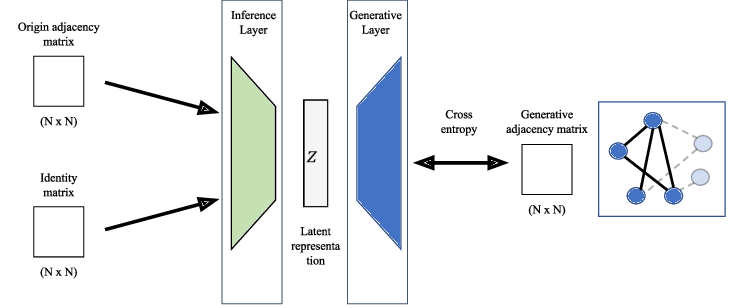

Encoder(Inference): Two layer Graph convolutional layer

Decoder(Generative): Pair-wise inner product of node imbeddings

[BCEWithLogitsLoss](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html): This loss combines a Sigmoid layer and the Binary Cross Entropy.

In [57]:
from torch_geometric.nn import GCNConv
from torch_geometric.utils import negative_sampling
from sklearn.metrics import roc_auc_score
import numpy as np

In [58]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [59]:
class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        #return the indices of a non-zero element
        return (prob_adj > 0).nonzero(as_tuple=False).t()

In [60]:
model = Net(data_train.num_features, 128, 64).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()

In [61]:
trainingEpoch_loss = []
def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(data_train.x, data_train.edge_index)

#     # We perform a new round of negative sampling for every training epoch:
#     neg_edge_index = negative_sampling(
#         edge_index=data_train.edge_index, num_nodes=data_train.num_nodes,
#         num_neg_samples=data_train.edge_label_index.size(1))

    edge_label_index = torch.cat(
        [data_train.edge_label_index],#neg_edge_index
        dim=-1,
    )
    edge_label = torch.cat([
        data_train.edge_label
    ], dim=0) #data_train.edge_label.new_zeros(neg_edge_index.size(1))

    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    trainingEpoch_loss.append(loss.detach().numpy())
    loss.backward()
    optimizer.step()
    return loss

@torch.no_grad()
def test(data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())

In [62]:
best_val_auc = final_test_auc = 0
validation_acc = []
for epoch in range(1, 100):
    loss = train()
    val_auc = test(data_test)
#     test_auc = test(data_test)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
#         final_test_auc = test_auc
    validation_acc.append(val_auc)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f},')
print(f'Final Test: {best_val_auc:.4f}')

Epoch: 001, Loss: 2384.0608, Val: 0.5000,
Epoch: 002, Loss: 491.7023, Val: 0.5003,
Epoch: 003, Loss: 334.6842, Val: 0.5003,
Epoch: 004, Loss: 488.1818, Val: 0.5003,
Epoch: 005, Loss: 478.8885, Val: 0.5006,
Epoch: 006, Loss: 357.1899, Val: 0.5000,
Epoch: 007, Loss: 227.8850, Val: 0.5003,
Epoch: 008, Loss: 137.4853, Val: 0.5003,
Epoch: 009, Loss: 91.5616, Val: 0.4997,
Epoch: 010, Loss: 73.8953, Val: 0.4997,
Epoch: 011, Loss: 70.0732, Val: 0.4994,
Epoch: 012, Loss: 68.0190, Val: 0.4994,
Epoch: 013, Loss: 63.4406, Val: 0.4994,
Epoch: 014, Loss: 56.8058, Val: 0.5004,
Epoch: 015, Loss: 49.1505, Val: 0.5002,
Epoch: 016, Loss: 41.7570, Val: 0.4989,
Epoch: 017, Loss: 35.6812, Val: 0.4989,
Epoch: 018, Loss: 30.7761, Val: 0.4988,
Epoch: 019, Loss: 26.6043, Val: 0.4995,
Epoch: 020, Loss: 22.9666, Val: 0.4972,
Epoch: 021, Loss: 19.5845, Val: 0.4956,
Epoch: 022, Loss: 16.5686, Val: 0.4942,
Epoch: 023, Loss: 13.9753, Val: 0.4983,
Epoch: 024, Loss: 11.8930, Val: 0.4965,
Epoch: 025, Loss: 10.3244, Val:

## Kết luận: 3 Yếu tố không ảnh hưởng đến liên kết

# Loss plot

<function matplotlib.pyplot.show(close=None, block=None)>

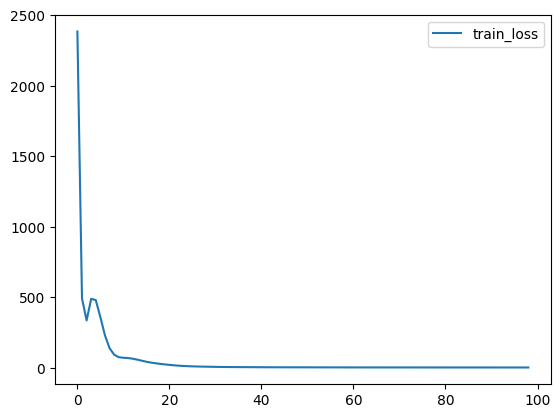

In [63]:
from matplotlib import pyplot as plt
plt.plot(trainingEpoch_loss, label='train_loss')
plt.legend()
plt.show

# Validation plot

<function matplotlib.pyplot.show(close=None, block=None)>

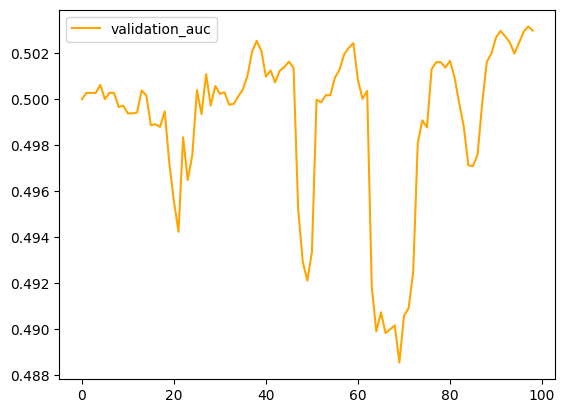

In [64]:
plt.plot(validation_acc, label = 'validation_auc', color = 'orange')
plt.legend()
plt.show

# Predict plot

In [65]:
z = model.encode(data_test.x, data_test.edge_index)
final_edge_index = model.decode(z,data_test.edge_label_index)

In [66]:
df_pred = pd.DataFrame(edge_label_index_test.T)
df_pred['Is_friend'] = edge_label_test
df_pred['predict'] = final_edge_index.detach().numpy()

In [67]:
df_pred

,0,1,Is_friend,predict
0,21986,1911,0,4.169809
1,12000,16506,0,0.450014
2,3290,16506,0,0.476316
3,5251,13879,0,-0.083318
4,17672,13879,0,7.541940
...,...,...,...,...
7484,12499,13093,0,-0.609667
7485,965,21485,0,-0.151014
7486,17851,18875,0,-0.607227
7487,18673,6309,0,0.476608


In [68]:
df_pred.predict.value_counts()

predict
 0.476285     487
-0.590515     268
 0.476608     179
-0.151014     179
 0.475916     137
             ... 
 20.148912      1
 0.458771       1
 5.329876       1
 22.925131      1
 0.476667       1
Name: count, Length: 997, dtype: int64

In [69]:
df_pred = df_pred[df_pred['predict'] > np.mean(df_pred['predict'])]

In [70]:
df_pred['Is_friend_pred'] = 1 
df_pred

,0,1,Is_friend,predict,Is_friend_pred
0,21986,1911,0,4.169809,1
4,17672,13879,0,7.541940,1
6,11274,7493,1,2.785820,1
8,5520,7493,1,3.906721,1
11,12329,7493,0,2.390618,1
...,...,...,...,...,...
7421,5622,23528,0,0.758844,1
7426,21517,15285,0,0.651349,1
7428,12499,17906,0,15.829581,1
7459,5520,11294,0,7.552091,1


In [71]:
G = nx.from_pandas_edgelist(df_pred, 0, 1, create_using = nx.Graph())

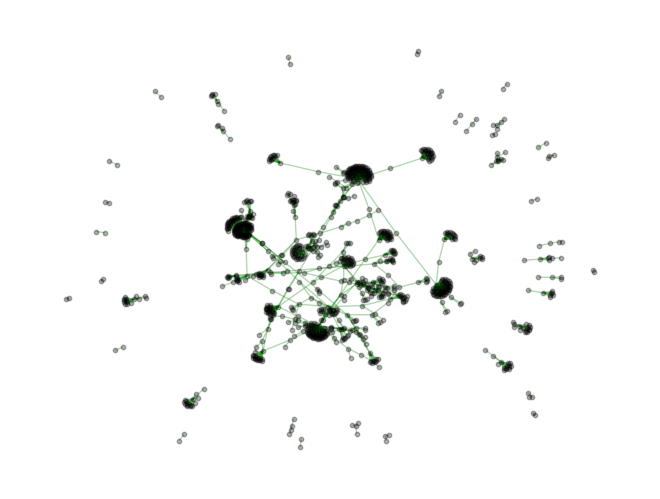

In [72]:
nx.draw(G,pos=nx.spring_layout(G),node_color='black',alpha=0.3,node_size=10,edge_color='green',width=1)